# Assignment 12

In this tutorium, we will work on GANs networks (https://arxiv.org/pdf/1406.2661.pdf). This kind of network is part of the generative networks who are actually able to generate synthetic data. This network is actually composed of two, a generator responsible for generate fake data and a discriminator for investigating on the trueness of the images.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://pathmind.com/images/wiki/GANs.png", width=700)

The disciminator can be see as a very simple fully connected network, composed of several layer of neurons and a simple output of one neurone who just determine if a image is true or false.

The generator looks more like the upscaling part of the segmenetation network. A small piece of noise is injected and the output is an images. 

The training is maybe the most original part. 

First, you train the discriminator alone by injecting the training set (True data so label=True) and a set of data generated by the generator (label=False) you then have a loss to back propagate. *Applause, you trained you discriminator for one batch*

Second, you inject some noise in your generator, the generator produce some fake images, you inject this fake images in you discriminator and use the labels generated by the discriminator to compute your backpropagation. So to train your generator, you will consider the generator and the discriminator as the same network, you just don't train the discriminator in this case.

## 12.1

We ask you then to program you own GANs. this network should be just compose of fully connected layer (no conv). You should define the architecture of the network, then provide two training function one for the generator and one for the discriminator and make him learn!

We will take the MNIST dataset here for simplicity and lightness. The architecture I used was :

G : (Input : random Tensor = 100) => (FC1 : fully connected = 256) => (BatchNormalisation) => (LeakyReLU) => (DropOut) => (FC2 : fully connected = 512) => (BatchNormalisation) => (LeakyReLU) => (DropOut) => (FC2 : fully connected = 784) =>  (Tanh)

D : (Input : flatten images Tensor = 784) => (FC1 : fully connected = 1024) => (BatchNormalisation) => (LeakyReLU) => (DropOut) => (FC2 : fully connected = 512) => (BatchNormalisation) => (LeakyReLU) => (DropOut) => (FC2 : fully connected = 1) =>  (Sigmoid)

This architecture is what I use, it's working but not great, so feel free to change it!!

The training is 20-30min on a 1060 6Go for 100 epochs and batch size of 100. Here, it's a little bit different than before, the loss do not necessarly go done, it's a race between D and G so both cannot be good at the same time.

In [30]:
# Hyper parameters
GENERATOR_INPUT_SIZE = 100
BATCH_SIZE = 100
LEARNING_RATE_G = 0.01
LEARNING_RATE_D = 0.01
MOMENTUM_G = 0.5
MOMENTUM_D = 0.5
# n_epochs = 3
# batch_size_train = 10
# batch_size_test = 1000
# log_interval = 10

# random_seed = 1
# torch.backends.cudnn.enabled = False
# torch.manual_seed(random_seed)

In [31]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
import torch.optim as optim
from torchvision.utils import save_image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pylab
import numpy as np

# If Cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image processing
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

# MNIST dataset
train_mnist = torchvision.datasets.MNIST(root='./data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_mnist,
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)

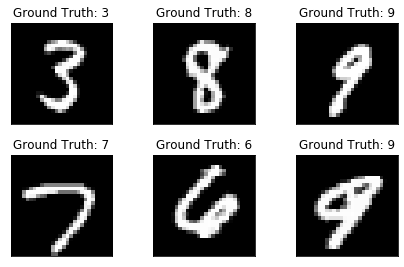

In [32]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3, i + 1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [45]:
class Discriminator(nn.Module):
    """
    D :
    (Input : flatten images Tensor = 784)
    => (FC1 : fully connected = 1024)
    => (BatchNormalisation)
    => (LeakyReLU)
    => (DropOut)
    => (FC2 : fully connected = 512)
    => (BatchNormalisation)
    => (LeakyReLU)
    => (DropOut)
    => (FC3 : fully connected = 1)
    => (Sigmoid)
    """
    
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(28**2, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            # Not more than 25%, http://iamtrask.github.io/2015/07/28/dropout/
            nn.Dropout(p=0.2),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(p=0.4),
            
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        # print(img.shape)
        flattened_img = img.view(img.size(0), -1)
        return self.seq(flattened_img)


class Generator(nn.Module):
    """
    G :
    (Input : random Tensor = 100)
    => (FC1 : fully connected = 256)
    => (BatchNormalisation)
    => (LeakyReLU)
    => (DropOut)
    => (FC2 : fully connected = 512)
    => (BatchNormalisation)
    => (LeakyReLU)
    => (DropOut)
    => (FC2 : fully connected = 784)
    => (Tanh)
    """
    
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(GENERATOR_INPUT_SIZE, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            # Not more than 25%, http://iamtrask.github.io/2015/07/28/dropout/
            nn.Dropout(p=0.2),
            
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(p=0.4),
            
            nn.Linear(512, 784),
            nn.Tanh(),
        )

    def forward(self, z):
        x = self.seq(z)
        img = x.view(x.size(0), 1, 28, 28)
        return img

In [57]:
# Loss function:
# In the paper, the GAN corresponds to a minimax 2-player game.
# As of
# https://developers.google.com/machine-learning/gan/loss#minimax-loss
# "Tthe formula derives from the cross-entropy between the real and generated distributions."
# Thus, we use a cross-entropy loss function pytorch provides:
# adversarial_loss = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()

G = Generator()
D = Discriminator()

G.to(device)
D.to(device)
criterion.to(device)

# Optimizers
# optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer_G = optim.SGD(G.parameters(), lr=LEARNING_RATE_G, momentum=MOMENTUM_G)
optimizer_D = optim.SGD(D.parameters(), lr=LEARNING_RATE_D, momentum=MOMENTUM_D)

In [64]:
def train(epochs=30, k=1):
    """
    Algorithm 1:
    Minibatch stochastic gradient descent training of generative adversarial nets.
    The number of steps to apply to the discriminator, k, is a hyperparameter.
    We used k = 1, the least expensive option, in our experiments.
    
    for number of training iterations do
        for k steps do
            • Sample minibatch of m noise samples {z(1), ... , z(m)} from noise prior pg(z).
            • Sample minibatch of m examples {x(1), ... , x(m)} from data generating distribution pdata (x).
            • Update the discriminator by ascending its stochastic gradient
        end for
        • Sample minibatch of m noise samples {z(1), . . . , z(m)} from noise prior pg(z).
        • Update the generator by descending its stochastic gradient
    end for

    The gradient-based updates can use any standard gradient-based learning rule.
    We used momentum in our experiments.
    
    ======================================================================
    
    The training is maybe the most original part:
    First, you train the discriminator alone by injecting the training set (True data so label=True)
    and a set of data generated by the generator (label=False) you then have a loss to back propagate.
    Applause, you trained you discriminator for one batch.
    Second, you inject some noise in your generator, the generator produce some fake images.
    You inject these fake images into your discriminator and use the labels
    generated by the discriminator to compute your backpropagation.
    So to train your generator, you will consider the generator and
    the discriminator as the same network, you just don't train the discriminator in this case.
    """
    
    for epoch in range(epochs):
        for step in range(k):
            for batch_idx, data in enumerate(train_loader):
                images, _labels = data
                batch_size = images.shape[0]
                labels_real = torch.ones(batch_size, 1,
                                         # dtype=torch.long,
                                         device=device,
                                         requires_grad=False)
                labels_fake = torch.zeros(batch_size, 1,
                                          #dtype=torch.long, 
                                          device=device, 
                                          requires_grad=False)
                
                optimizer_D.zero_grad()
                optimizer_G.zero_grad()
                
                # > First, you train the discriminator alone
                # > by injecting the training set (true data so label=True)
                output_real = D(images)
                # > and a set of data generated by the generator (label=False).
                # Create random/noise tensors (z space) as inputs for the generator.
                z = torch.randn(batch_size, GENERATOR_INPUT_SIZE)
                generated_imgs = G(z)
#                 output_fake = D(generated_imgs)
                output_fake = D(generated_imgs.detach())
                # > You then have a loss to back propagate.
                # Measure discriminator's ability to classify real from generated samples
                real_loss = criterion(output_real, labels_real)
                fake_loss = criterion(output_fake, labels_fake)
                # loss_D = (real_loss + fake_loss) / 2
                loss_D = real_loss + fake_loss
                loss_D.backward()
                # > Applause, you trained you discriminator for one batch.
                
                
                # > Second, you inject some noise in your generator,
                # > the generator produces some fake images.
                # > You inject these fake images into your discriminator
                # > and use the labels generated by the discriminator
                # > to compute your backpropagation.
                # > So to train your generator, you will consider the generator and
                # > the discriminator as the same network,
                # > you just don't train the discriminator in this case.
                
                
                
#                 # Sample noise (z space) as input for the generator
#                 # z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))
#                 # Generate a batch of images
#                 generated_imgs = G(z)
                loss_G = criterion(D(generated_imgs), labels_real)
                loss_G.backward()
                
                optimizer_G.step()
                optimizer_D.step()
                
                print(
                    "[epoch %d/%d] [batch %d/%d] [loss D: %f] [loss G: %f]"
                    % (
                        epoch, epochs,
                        batch_idx, len(train_loader),
                        loss_D.item(),
                        loss_G.item(),
                    )
                )
                
                # Sample minibatch of m noise samples
                # Sample minibatch of m examples
                # SGD discriminator w/ momentum

            # sample minibatch of m noise samples
            # SCD generator w/ momentum

In [ ]:
train()

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 0/600] [loss D: 1.494803] [loss G: 0.714208]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 1/600] [loss D: 1.474733] [loss G: 0.549461]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 2/600] [loss D: 1.569189] [loss G: 0.404111]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 3/600] [loss D: 1.611714] [loss G: 0.367801]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 4/600] [loss D: 1.656830] [loss G: 0.353337]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 5/600] [loss D: 1.589793] [loss G: 0.406148]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[

torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 55/600] [loss D: 1.478762] [loss G: 0.420008]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 56/600] [loss D: 1.552220] [loss G: 0.410841]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 57/600] [loss D: 1.541554] [loss G: 0.413837]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 58/600] [loss D: 1.570645] [loss G: 0.411545]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 59/600] [loss D: 1.519274] [loss G: 0.413118]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 60/600] [loss D: 1.485073] [loss G: 0.421841]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 61/600] [loss D: 1.492619] [loss 

[epoch 0/30] [batch 109/600] [loss D: 1.507689] [loss G: 0.415160]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 110/600] [loss D: 1.504999] [loss G: 0.419975]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 111/600] [loss D: 1.483050] [loss G: 0.417873]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 112/600] [loss D: 1.513861] [loss G: 0.410666]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 113/600] [loss D: 1.486318] [loss G: 0.415119]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 114/600] [loss D: 1.515301] [loss G: 0.400925]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 115/600] [loss D: 1.507866] [loss G: 0.414393]
torch.Siz

torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 163/600] [loss D: 1.496271] [loss G: 0.418261]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 164/600] [loss D: 1.524505] [loss G: 0.406788]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 165/600] [loss D: 1.500544] [loss G: 0.402780]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 166/600] [loss D: 1.494998] [loss G: 0.410685]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 167/600] [loss D: 1.516207] [loss G: 0.421277]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 168/600] [loss D: 1.494944] [loss G: 0.412013]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 169/600] [loss D: 1.490344]

[epoch 0/30] [batch 218/600] [loss D: 1.508855] [loss G: 0.407070]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 219/600] [loss D: 1.488004] [loss G: 0.418151]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 220/600] [loss D: 1.512835] [loss G: 0.421067]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 221/600] [loss D: 1.520285] [loss G: 0.416196]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 222/600] [loss D: 1.508728] [loss G: 0.411103]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 223/600] [loss D: 1.502005] [loss G: 0.402429]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 224/600] [loss D: 1.508569] [loss G: 0.407002]
torch.Siz

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 273/600] [loss D: 1.495249] [loss G: 0.419043]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 274/600] [loss D: 1.505673] [loss G: 0.419478]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 275/600] [loss D: 1.503538] [loss G: 0.405324]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 276/600] [loss D: 1.521046] [loss G: 0.413797]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 277/600] [loss D: 1.506107] [loss G: 0.410555]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 278/600] [loss D: 1.500486] [loss G: 0.406427]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batc

torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 327/600] [loss D: 1.522861] [loss G: 0.407035]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 328/600] [loss D: 1.494855] [loss G: 0.415683]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 329/600] [loss D: 1.498468] [loss G: 0.411256]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 330/600] [loss D: 1.503059] [loss G: 0.415887]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 331/600] [loss D: 1.505077] [loss G: 0.411865]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 332/600] [loss D: 1.505544] [loss G: 0.410157]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 333/600] [loss D: 1.507082]

torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 382/600] [loss D: 1.512215] [loss G: 0.405656]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 383/600] [loss D: 1.507695] [loss G: 0.412987]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 384/600] [loss D: 1.507626] [loss G: 0.417834]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 385/600] [loss D: 1.507906] [loss G: 0.402738]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 386/600] [loss D: 1.511869] [loss G: 0.413515]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 387/600] [loss D: 1.498770] [loss G: 0.408332]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 388/600] [loss D: 1.503123]

torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 437/600] [loss D: 1.491035] [loss G: 0.408949]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 438/600] [loss D: 1.512359] [loss G: 0.413160]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 439/600] [loss D: 1.504725] [loss G: 0.412064]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 440/600] [loss D: 1.506642] [loss G: 0.406059]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 441/600] [loss D: 1.502902] [loss G: 0.405969]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 442/600] [loss D: 1.501914] [loss G: 0.412899]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 443/600] [loss D: 1.515481]

torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 491/600] [loss D: 1.483553] [loss G: 0.412076]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 492/600] [loss D: 1.502699] [loss G: 0.414903]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 493/600] [loss D: 1.499285] [loss G: 0.415368]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 494/600] [loss D: 1.501321] [loss G: 0.410057]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 495/600] [loss D: 1.489075] [loss G: 0.411901]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 496/600] [loss D: 1.511441] [loss G: 0.411492]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 497/600] [loss D: 1.516123]

torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 546/600] [loss D: 1.501403] [loss G: 0.421133]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 547/600] [loss D: 1.510104] [loss G: 0.416636]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 548/600] [loss D: 1.513865] [loss G: 0.418674]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 549/600] [loss D: 1.505915] [loss G: 0.412875]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 550/600] [loss D: 1.496477] [loss G: 0.414554]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 551/600] [loss D: 1.508773] [loss G: 0.414604]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 0/30] [batch 552/600] [loss D: 1.506654]

[epoch 1/30] [batch 0/600] [loss D: 1.515277] [loss G: 0.407797]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 1/600] [loss D: 1.494669] [loss G: 0.419706]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 2/600] [loss D: 1.484771] [loss G: 0.417183]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 3/600] [loss D: 1.486426] [loss G: 0.411226]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 4/600] [loss D: 1.495391] [loss G: 0.410904]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 5/600] [loss D: 1.520733] [loss G: 0.410074]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 6/600] [loss D: 1.485717] [loss G: 0.407022]
torch.Size([100, 1, 28,

torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 54/600] [loss D: 1.499627] [loss G: 0.404429]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 55/600] [loss D: 1.520703] [loss G: 0.402577]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 56/600] [loss D: 1.510317] [loss G: 0.411366]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 57/600] [loss D: 1.507054] [loss G: 0.406243]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 58/600] [loss D: 1.497536] [loss G: 0.427049]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 59/600] [loss D: 1.512408] [loss G: 0.400813]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 60/600] [loss D: 1.497512] [loss 

torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 109/600] [loss D: 1.504730] [loss G: 0.407048]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 110/600] [loss D: 1.509960] [loss G: 0.410496]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 111/600] [loss D: 1.509792] [loss G: 0.407663]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 112/600] [loss D: 1.499255] [loss G: 0.410349]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 113/600] [loss D: 1.491283] [loss G: 0.416961]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 114/600] [loss D: 1.507257] [loss G: 0.400815]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 115/600] [loss D: 1.500749]

torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 163/600] [loss D: 1.496536] [loss G: 0.404164]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 164/600] [loss D: 1.503894] [loss G: 0.419392]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 165/600] [loss D: 1.491802] [loss G: 0.415048]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 166/600] [loss D: 1.491296] [loss G: 0.418709]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 167/600] [loss D: 1.499342] [loss G: 0.415195]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 168/600] [loss D: 1.499074] [loss G: 0.403722]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 169/600] [loss D: 1.500603]

torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 218/600] [loss D: 1.516291] [loss G: 0.408243]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 219/600] [loss D: 1.506322] [loss G: 0.400786]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 220/600] [loss D: 1.509802] [loss G: 0.406722]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 221/600] [loss D: 1.510132] [loss G: 0.422894]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 222/600] [loss D: 1.496452] [loss G: 0.417659]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 223/600] [loss D: 1.486319] [loss G: 0.420798]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 224/600] [loss D: 1.483959]

torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 272/600] [loss D: 1.485666] [loss G: 0.407567]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 273/600] [loss D: 1.502636] [loss G: 0.399642]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 274/600] [loss D: 1.501625] [loss G: 0.416972]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 275/600] [loss D: 1.501187] [loss G: 0.418739]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 276/600] [loss D: 1.486007] [loss G: 0.419692]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 277/600] [loss D: 1.509567] [loss G: 0.400899]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 278/600] [loss D: 1.475532]

torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 327/600] [loss D: 1.492602] [loss G: 0.411327]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 328/600] [loss D: 1.497054] [loss G: 0.412058]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 329/600] [loss D: 1.509820] [loss G: 0.404535]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 330/600] [loss D: 1.518654] [loss G: 0.415506]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 331/600] [loss D: 1.525736] [loss G: 0.412695]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 332/600] [loss D: 1.491857] [loss G: 0.401572]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 333/600] [loss D: 1.500098]

torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 381/600] [loss D: 1.488844] [loss G: 0.410462]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 382/600] [loss D: 1.491760] [loss G: 0.412519]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 383/600] [loss D: 1.490399] [loss G: 0.414954]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 384/600] [loss D: 1.484217] [loss G: 0.417848]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 385/600] [loss D: 1.496054] [loss G: 0.413768]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 386/600] [loss D: 1.516299] [loss G: 0.411112]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 387/600] [loss D: 1.496474]

[epoch 1/30] [batch 436/600] [loss D: 1.485135] [loss G: 0.414165]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 437/600] [loss D: 1.489969] [loss G: 0.412455]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 438/600] [loss D: 1.477594] [loss G: 0.422816]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 439/600] [loss D: 1.506464] [loss G: 0.418312]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 440/600] [loss D: 1.499359] [loss G: 0.427922]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 441/600] [loss D: 1.488349] [loss G: 0.419629]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 442/600] [loss D: 1.496639] [loss G: 0.416176]
torch.Siz

torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 490/600] [loss D: 1.488064] [loss G: 0.421497]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 491/600] [loss D: 1.511499] [loss G: 0.428742]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 492/600] [loss D: 1.498782] [loss G: 0.412121]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 493/600] [loss D: 1.532147] [loss G: 0.411919]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 494/600] [loss D: 1.512555] [loss G: 0.420572]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 495/600] [loss D: 1.466968] [loss G: 0.417223]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 496/600] [loss D: 1.491851]

torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 544/600] [loss D: 1.491373] [loss G: 0.413349]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 545/600] [loss D: 1.509288] [loss G: 0.410891]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 546/600] [loss D: 1.494798] [loss G: 0.413357]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 547/600] [loss D: 1.494648] [loss G: 0.420577]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 548/600] [loss D: 1.484861] [loss G: 0.418904]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 549/600] [loss D: 1.501499] [loss G: 0.418842]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 1/30] [batch 550/600] [loss D: 1.483983]

[epoch 1/30] [batch 599/600] [loss D: 1.505954] [loss G: 0.416456]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 0/600] [loss D: 1.485137] [loss G: 0.421680]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 1/600] [loss D: 1.496095] [loss G: 0.409557]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 2/600] [loss D: 1.499772] [loss G: 0.419752]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 3/600] [loss D: 1.479361] [loss G: 0.424832]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 4/600] [loss D: 1.472132] [loss G: 0.421743]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 5/600] [loss D: 1.459561] [loss G: 0.412445]
torch.Size([100, 1, 2

torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 54/600] [loss D: 1.497514] [loss G: 0.410156]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 55/600] [loss D: 1.490786] [loss G: 0.423160]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 56/600] [loss D: 1.474157] [loss G: 0.427018]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 57/600] [loss D: 1.508490] [loss G: 0.406150]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 58/600] [loss D: 1.511904] [loss G: 0.408603]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 59/600] [loss D: 1.465577] [loss G: 0.424181]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 60/600] [loss D: 1.486470] [loss 

[epoch 2/30] [batch 108/600] [loss D: 1.494966] [loss G: 0.419143]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 109/600] [loss D: 1.484353] [loss G: 0.413952]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 110/600] [loss D: 1.493773] [loss G: 0.414196]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 111/600] [loss D: 1.498345] [loss G: 0.410798]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 112/600] [loss D: 1.479079] [loss G: 0.416364]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 113/600] [loss D: 1.458195] [loss G: 0.410034]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 114/600] [loss D: 1.504905] [loss G: 0.422209]
torch.Siz

torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 162/600] [loss D: 1.462865] [loss G: 0.416875]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 163/600] [loss D: 1.487624] [loss G: 0.419605]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 164/600] [loss D: 1.462700] [loss G: 0.416292]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 165/600] [loss D: 1.485818] [loss G: 0.423657]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 166/600] [loss D: 1.501349] [loss G: 0.424137]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 167/600] [loss D: 1.476624] [loss G: 0.424117]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 168/600] [loss D: 1.487797]

[epoch 2/30] [batch 217/600] [loss D: 1.489802] [loss G: 0.413083]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 218/600] [loss D: 1.510373] [loss G: 0.408746]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 219/600] [loss D: 1.500878] [loss G: 0.428759]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 220/600] [loss D: 1.488151] [loss G: 0.414405]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 221/600] [loss D: 1.460744] [loss G: 0.438626]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 222/600] [loss D: 1.470985] [loss G: 0.421935]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 223/600] [loss D: 1.483017] [loss G: 0.416382]
torch.Siz

torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 271/600] [loss D: 1.472955] [loss G: 0.427262]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 272/600] [loss D: 1.470757] [loss G: 0.427928]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 273/600] [loss D: 1.487183] [loss G: 0.416901]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 274/600] [loss D: 1.440972] [loss G: 0.429180]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 275/600] [loss D: 1.481966] [loss G: 0.421516]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 276/600] [loss D: 1.460868] [loss G: 0.418365]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 277/600] [loss D: 1.460649]

torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 325/600] [loss D: 1.482108] [loss G: 0.423157]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 326/600] [loss D: 1.466695] [loss G: 0.431481]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 327/600] [loss D: 1.454947] [loss G: 0.415772]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 328/600] [loss D: 1.449707] [loss G: 0.436723]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 329/600] [loss D: 1.449809] [loss G: 0.432087]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 330/600] [loss D: 1.476274] [loss G: 0.419770]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 331/600] [loss D: 1.458167]

torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 380/600] [loss D: 1.468006] [loss G: 0.425798]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 381/600] [loss D: 1.439774] [loss G: 0.436124]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 382/600] [loss D: 1.463844] [loss G: 0.408729]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 383/600] [loss D: 1.452002] [loss G: 0.414239]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 384/600] [loss D: 1.486615] [loss G: 0.414041]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 385/600] [loss D: 1.459883] [loss G: 0.437725]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 386/600] [loss D: 1.473173]

torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 434/600] [loss D: 1.443174] [loss G: 0.428641]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 435/600] [loss D: 1.444878] [loss G: 0.442992]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 436/600] [loss D: 1.434254] [loss G: 0.445137]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 437/600] [loss D: 1.439152] [loss G: 0.414718]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 438/600] [loss D: 1.464331] [loss G: 0.418329]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 439/600] [loss D: 1.454289] [loss G: 0.424882]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 440/600] [loss D: 1.452672]

[epoch 2/30] [batch 489/600] [loss D: 1.457175] [loss G: 0.437038]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 490/600] [loss D: 1.480224] [loss G: 0.454069]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 491/600] [loss D: 1.450876] [loss G: 0.436272]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 492/600] [loss D: 1.448106] [loss G: 0.442938]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 493/600] [loss D: 1.446451] [loss G: 0.435547]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 494/600] [loss D: 1.472683] [loss G: 0.454713]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 495/600] [loss D: 1.452034] [loss G: 0.436889]
torch.Siz

torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 543/600] [loss D: 1.457637] [loss G: 0.430474]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 544/600] [loss D: 1.480954] [loss G: 0.432917]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 545/600] [loss D: 1.455618] [loss G: 0.426509]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 546/600] [loss D: 1.479503] [loss G: 0.415623]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 547/600] [loss D: 1.452367] [loss G: 0.443548]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 548/600] [loss D: 1.420184] [loss G: 0.445520]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 549/600] [loss D: 1.446680]

torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 597/600] [loss D: 1.423954] [loss G: 0.431858]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 598/600] [loss D: 1.425612] [loss G: 0.453122]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 2/30] [batch 599/600] [loss D: 1.448175] [loss G: 0.437805]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 3/30] [batch 0/600] [loss D: 1.421520] [loss G: 0.434673]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 3/30] [batch 1/600] [loss D: 1.463525] [loss G: 0.452002]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 3/30] [batch 2/600] [loss D: 1.444214] [loss G: 0.452287]
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
[epoch 3/30] [batch 3/600] [loss D: 1.432666] [loss G

## 8.2 Bonus
For the bonus, fancy stuff we would like you to program a conditional GAN. This GAN should produce the output you want. Instead of feeding your generator with just noise, you feed it with noise and label and it should generated the number you want. 
To do so, you add a label part to your Generator's input and you tell your discriminator what number it should recognize by adding a label part to your Discriminator's input.


In [10]:
Image(url= "https://raw.githubusercontent.com/znxlwm/pytorch-MNIST-CelebA-cGAN-cDCGAN/master/pytorch_cGAN.png", width=900)

In [ ]:
#ToDo